# Neighbor regularization

Test implementation of cKDTree and other methods to compute the difference between a point and its nearest neighbors.

In [68]:
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
import re
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        data = []
        for n,line in enumerate(f,1):
            if n==1:
                line = line.strip()
                line = re.findall(r'"[^"]*"', line) # get ['"var_name1"', '"var_name2"', ...]
                column_labels = [var_name.replace('"','') for var_name in line]
            elif n==2:
                continue
            else:
                data_line = [eval(data) for data in line.split()]
                if len(data_line)==4:
                    break
                data.append(data_line)
    return pd.DataFrame(data, columns=column_labels)

In [3]:
file = Path('/Users/jarl/2d-discharge-nn/data/avg_data/200Vpp_100Pa_node.dat')

In [4]:
df = read_file(file)[['X', 'Y', 'potential (V)']]
df.head()

,X,Y,potential (V)
0,0.182960,0.259570,17.4177
1,0.172908,0.266347,27.8613
2,0.173172,0.254322,18.8931
3,0.176840,0.246447,11.5936
4,0.170305,0.246504,13.0860


In [5]:
X = df.X.to_numpy()  # units: m
Y = df.Y.to_numpy()

## cKDTree test

Create a cKDTree given the list of points `X` and `Y`. 

`query` queries the kd-tree for the nearest neighbors. [Link to documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query). 

`np.c` combines `X` and `Y` as columns. 

In [6]:
tree = cKDTree(np.c_[X,Y])

Test usage with tensors using dummy data:

In [217]:
# x, y, v, p
x = np.linspace(0, 20, 4)
y = np.linspace(0, 70, 9)
xx, yy = np.meshgrid(x, y)
v = 300.0
p = 60.0

In [218]:
# feature columns
features = pd.DataFrame({'x':xx.reshape(-1), 'y':yy.reshape(-1)})
features['v'] = v
features['p'] = p
# features['x**2'] = features['x']**2
# features['y**2'] = features['y']**2

features.head()

,x,y,v,p
0,0.000000,0.00,300.0,60.0
1,6.666667,0.00,300.0,60.0
2,13.333333,0.00,300.0,60.0
3,20.000000,0.00,300.0,60.0
4,0.000000,8.75,300.0,60.0


In [219]:
tree = cKDTree(np.c_[features['x'], features['y']])

In [220]:
# label columns
labels = pd.DataFrame(np.random.rand(len(features), 5), columns=['potential', 'ne', 'ni', 'nm', 'te'])
labels.head()

,potential,ne,ni,nm,te
0,0.351071,0.096043,0.488007,0.919554,0.776933
1,0.194773,0.475717,0.915792,0.420179,0.961647
2,0.726976,0.684283,0.490202,0.588397,0.314454
3,0.938420,0.679655,0.801562,0.922744,0.710857
4,0.586078,0.797734,0.626672,0.540167,0.399757


In [254]:
data = tf.data.Dataset.from_tensor_slices((features, labels)).batch(3)

In [280]:
k = 3
for (x_batch_train, y_batch_train) in data:
    y_pred = model(x_batch_train)
    for i, point in enumerate(x_batch_train):
        x, y, v, p = point  # unpack point, returns tensors
        v = np.array([v.numpy()])  # convert tensor to 1D vector (numpy)
        p = np.array([p.numpy()])

        _, ii = tree.query([x, y], k=k)  # get nearest k neighbors of point (x,y)
        
        # get pair of x, y of all neighbors
        neighbor_xy = [df[['x', 'y']].iloc[i].to_numpy() for i in ii]

        # combine (x,y) with v and p, as input to the model
        neighbors = [np.concatenate((xy, v, p)) for xy in neighbor_xy]

        # convert to tensor
        neighbors = [tf.expand_dims(tf.convert_to_tensor(neighbor), axis=0) for neighbor in neighbors]

        # make prediction for all neighbors of the point
        neighbor_pred = [model(neighbor) for neighbor in neighbors]
        
        # get mean of neighbor predictions for 5 variables
        means = tf.reduce_mean([neighbor for neighbor in neighbor_pred], axis=1)
    
    print(0.3*tf.losses.mean_squared_error(means, y_batch_train))

    
    

tf.Tensor([0.24748616 0.30564182 0.29506969], shape=(3,), dtype=float64)
tf.Tensor([0.24748616 0.30564182 0.29506969], shape=(3,), dtype=float64)
tf.Tensor([0.24748616 0.30564182 0.29506969], shape=(3,), dtype=float64)
tf.Tensor([0.38918977 0.31973623 0.20157812], shape=(3,), dtype=float64)
tf.Tensor([0.38918977 0.31973623 0.20157812], shape=(3,), dtype=float64)
tf.Tensor([0.38918977 0.31973623 0.20157812], shape=(3,), dtype=float64)
tf.Tensor([0.31598856 0.25223201 0.23174267], shape=(3,), dtype=float64)
tf.Tensor([0.31598856 0.25223201 0.23174267], shape=(3,), dtype=float64)
tf.Tensor([0.31598856 0.25223201 0.23174267], shape=(3,), dtype=float64)
tf.Tensor([0.17961698 0.20304914 0.35809458], shape=(3,), dtype=float64)
tf.Tensor([0.17961698 0.20304914 0.35809458], shape=(3,), dtype=float64)
tf.Tensor([0.17961698 0.20304914 0.35809458], shape=(3,), dtype=float64)
tf.Tensor([0.34534523 0.21476249 0.34180521], shape=(3,), dtype=float64)
tf.Tensor([0.34534523 0.21476249 0.34180521], shape

In [282]:
y_batch_train

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[0.03899989, 0.73334493, 0.35479274, 0.67773742, 0.39150748],
       [0.94248444, 0.72652378, 0.9409817 , 0.8066283 , 0.87304629],
       [0.58340791, 0.86220683, 0.18134004, 0.51998069, 0.39729301]])>

In [275]:
model(tf.expand_dims(neighbors[0], axis=0))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.27548128, -1.2672136 ,  0.4513415 , -0.17220855, -0.25616783]],
      dtype=float32)>

In [264]:
for (x_batch_train, y_batch_train) in data:
    print(model(x_batch_train))

tf.Tensor(
[[ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 0.27548128 -1.2672136   0.4513415  -0.17220855 -0.25616783]
 [

In [246]:
from tensorflow import keras

input = keras.Input(shape=(len(features.columns),) )
hidden = keras.layers.Dense(10, activation=tf.nn.sigmoid)(input)
output = keras.layers.Dense(len(labels.columns))(hidden)

model = keras.Model(input, output)

In [247]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_13 (Dense)            (None, 10)                50        
                                                                 
 dense_14 (Dense)            (None, 5)                 55        
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [114]:
model(x_batch_train)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.4139608 , -0.4452355 , -0.02437806,  0.46839964,  0.08675146],
       [-0.4139608 , -0.4452355 , -0.02437806,  0.46839964,  0.08675146],
       [-0.4139608 , -0.4452355 , -0.02437806,  0.46839964,  0.08675146]],
      dtype=float32)>

In [7]:
# return distances (dd) and indices (ii) of the 6 nearest neighbors to the point 0.06 (x), 0.42 (y)
dd, ii = tree.query([0.06, 0.42], k=6)

point = df['potential (V)'].iloc[ii[0]]
print(f'potential at point: {point}')

# get the mean of potential of the nearest neighbors
mean = df['potential (V)'].iloc[ii].mean()
print(f'mean around point: {mean}')

diff = np.abs(point-mean)
print(f'difference: {diff}')

potential at point: 51.5985
mean around point: 51.57316666666666
difference: 0.025333333333342978


## A different approach

This may work, but iterating over all points to evaluate the difference might be computationally expensive. Instead, it might be better to perform a filter operation over an image with SciPy. 

`scipy.ndimage.generic_filter` can compute a function over all values in an array, replacing the central value by the function output.

In [8]:
file2 = Path('/Users/jarl/2d-discharge-nn/data/interpolation_datasets/rec-interpolation2.nc')

### Open linearly interpolated dataset

In [9]:
ds = xr.open_dataset(file2)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [10]:
ds['potential (V)'].sel(V=200, P=100)

<xarray.DataArray 'potential (V)' (y: 707, x: 200)>
[141400 values with dtype=float64]
Coordinates:
  * y        (y) float64 0.0 0.001 0.002 0.003 0.004 ... 0.703 0.704 0.705 0.706
  * x        (x) float64 0.0 0.001 0.002 0.003 0.004 ... 0.196 0.197 0.198 0.199
    P        float64 100.0
    V        float64 200.0

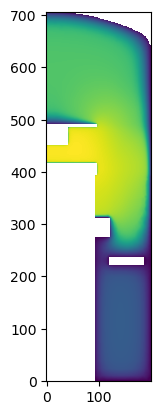

In [11]:
potential = ds['potential (V)'].sel(V=200, P=100).to_numpy()
plt.imshow(potential, origin='lower')

The footprint (`fp`) is a boolean array that specifies a shape, and selects which of the elements in the shape get passed to the filter function. Since we are taking the average of the surrounding pixels, it'll be a 3x3 array with a 0 at the center to exclude it.

In [12]:
fp = np.array([[1, 1, 1],
               [1, 0, 1],
               [1, 1, 1]])

In [13]:
from scipy.ndimage import generic_filter

potential_mean = generic_filter(potential, function=np.mean, footprint=fp)

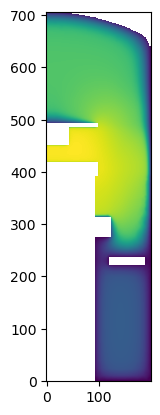

In [14]:
plt.imshow(potential_mean, origin='lower')

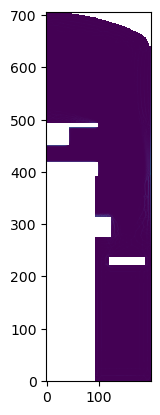

In [15]:
plt.imshow(np.abs(potential_mean - potential)*100, origin='lower')

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.nan_to_num(potential_mean), np.nan_to_num(potential))

2.82038333963053